## Setup

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE




In [38]:
print(tf.__version__)
print(keras.__version__)
# Some times it will report weird error when versions not matching. 
# If neccessary you can manually specify version when you install it, or upgrade/downgrade afterwards.

2.6.0
2.6.0


In [3]:
# The batch_size here decide the batch_size in training.
# the original paper sugguest batch_size =1. Can we try bigger batche size?

# replace the directory with you own dataset location 
mydata1 = tf.keras.preprocessing.image_dataset_from_directory(
  "C:\\Users\\chris\\Documents\\study\\3rd\\DL\\Datasets\\CatHuman\\human",
  seed=123,
  label_mode=None,
  image_size=(256, 256),
  batch_size=2)
#zebra training set
mydata2 = tf.keras.preprocessing.image_dataset_from_directory(
  "C:\\Users\\chris\\Documents\\study\\3rd\\DL\\Datasets\\CatHuman\\catface",
  seed=123,
  label_mode=None,
  image_size=(256, 256),
  batch_size=2)

Found 3049 files belonging to 1 classes.
Found 1170 files belonging to 1 classes.


In [4]:
#  Define preprocessing funtions, bascially same as this demo, but a bit different when using `tf.image.random_crop`, and has to remove the `label` argument.
def myPreprocessing_train(img):
    #img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img,(286,286))
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=(1,256, 256, 3))

    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0
def myPreprocessing_test(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, (256,256))
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0



In [5]:
processed_data1=mydata1.map(myPreprocessing_train,num_parallel_calls=autotune)
processed_data2=mydata2.map(myPreprocessing_train,num_parallel_calls=autotune)

In [6]:
# take non-preprocessed data as input! this function is for left-right flipping and random crop.
# since the left-right flipping and crop are both random, you can use it multiple times for augementation,
def left_right_flip(img):
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img,(350,350))
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=(1,256, 256, 3))

    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

## Do augmentation according to your own dataset and your demand

In [7]:
# merge original dataset and fliped dataset to get a bigger dataset.
# do this according to you dataset and what you need

# fliped_data=mydata2.map(left_right_flip,num_parallel_calls=autotune)
# processed_data2=processed_data2.concatenate(fliped_data)

finished


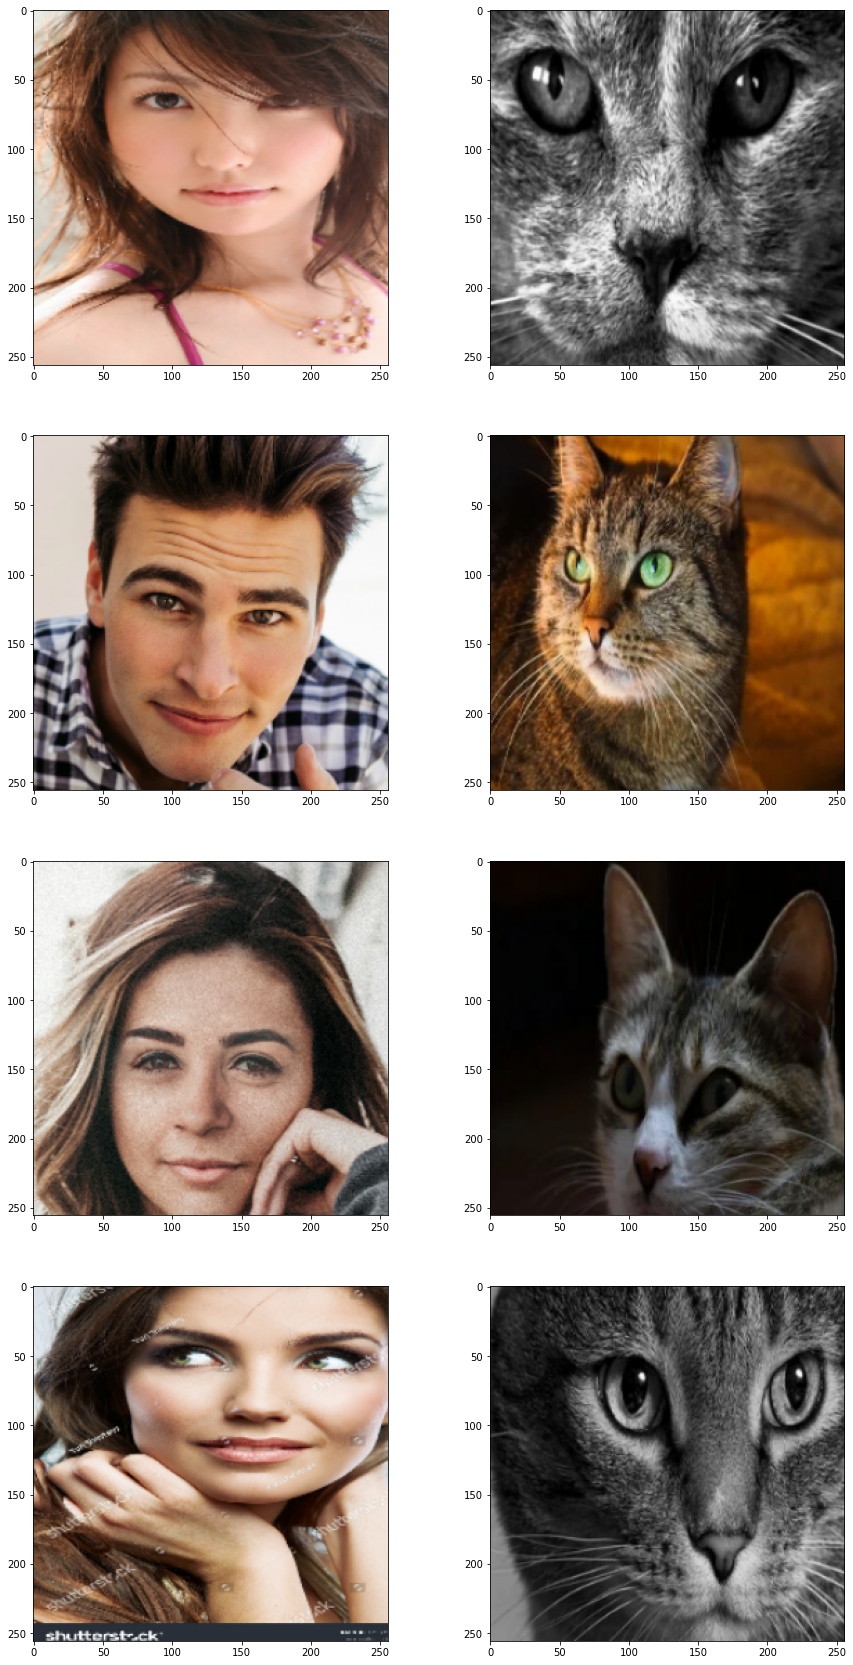

In [8]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(4, 2, figsize=(15, 30))

#list(enumerate(zip(processed_data1, processed_data2)))

for i, samples in enumerate(zip(processed_data1.take(4), processed_data2.take(4))):
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
        
# except:
#     print('aaa')
print("finished")
plt.show()

In [10]:
# # Load the horse-zebra dataset using tensorflow-datasets.
# dataset, _ = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)
# train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
# test_horses, test_zebras = dataset["testA"], dataset["testB"]

# # Define the standard image size.
orig_img_size = (286, 286)
# # Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# # Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# # Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256

## Building blocks used in the CycleGAN generators and discriminators

Note (ADAM): This is just class that implements padding, so that the layers of the CNN don't reduce the size of the image drastically. This specific padding is called reflection padding where the values of the original images are reflected on the padding: (e.g. 351 is reflected as 15 on the left side and 53 on the right side).
![image.png](https://i.ibb.co/m8xrnbK/image.png)

In [11]:

class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


## Build the generators

The generator consists of downsampling blocks: nine residual blocks
and upsampling blocks. The structure of the generator is the following:

```
c7s1-64 ==> Conv block with `relu` activation, filter size of 7
d128 ====|
         |-> 2 downsampling blocks
d256 ====|
R256 ====|
R256     |
R256     |
R256     |
R256     |-> 9 residual blocks
R256     |
R256     |
R256     |
R256 ====|
u128 ====|
         |-> 2 upsampling blocks
u64  ====|
c7s1-3 => Last conv block with `tanh` activation, filter size of 7.
```



In [12]:

def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


## Build the discriminators

The discriminators implement the following architecture:
`C64->C128->C256->C512`

In [13]:

def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")


## Build the CycleGAN model

We will override the `train_step()` method of the `Model` class
for training via `fit()`.

In [14]:

class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10,
        lambda_identity=0.5, # should be 0.5 * lambda_cycle according to the paper! not 0.5. But do we really  need this? This loss is just for preserve hue of the original picture.
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


## Compile the model. Then after this you can load saved weight

In [39]:

# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)



Test the performance of the model.

In [17]:
mytest = tf.keras.preprocessing.image_dataset_from_directory(
  "./testdata/human",
  seed=123,
  label_mode=None,
  image_size=(256, 256),
  batch_size=1)

mytest=mytest.map(myPreprocessing_train,num_parallel_calls=autotune)

Found 5 files belonging to 1 classes.


Weights loaded successfully


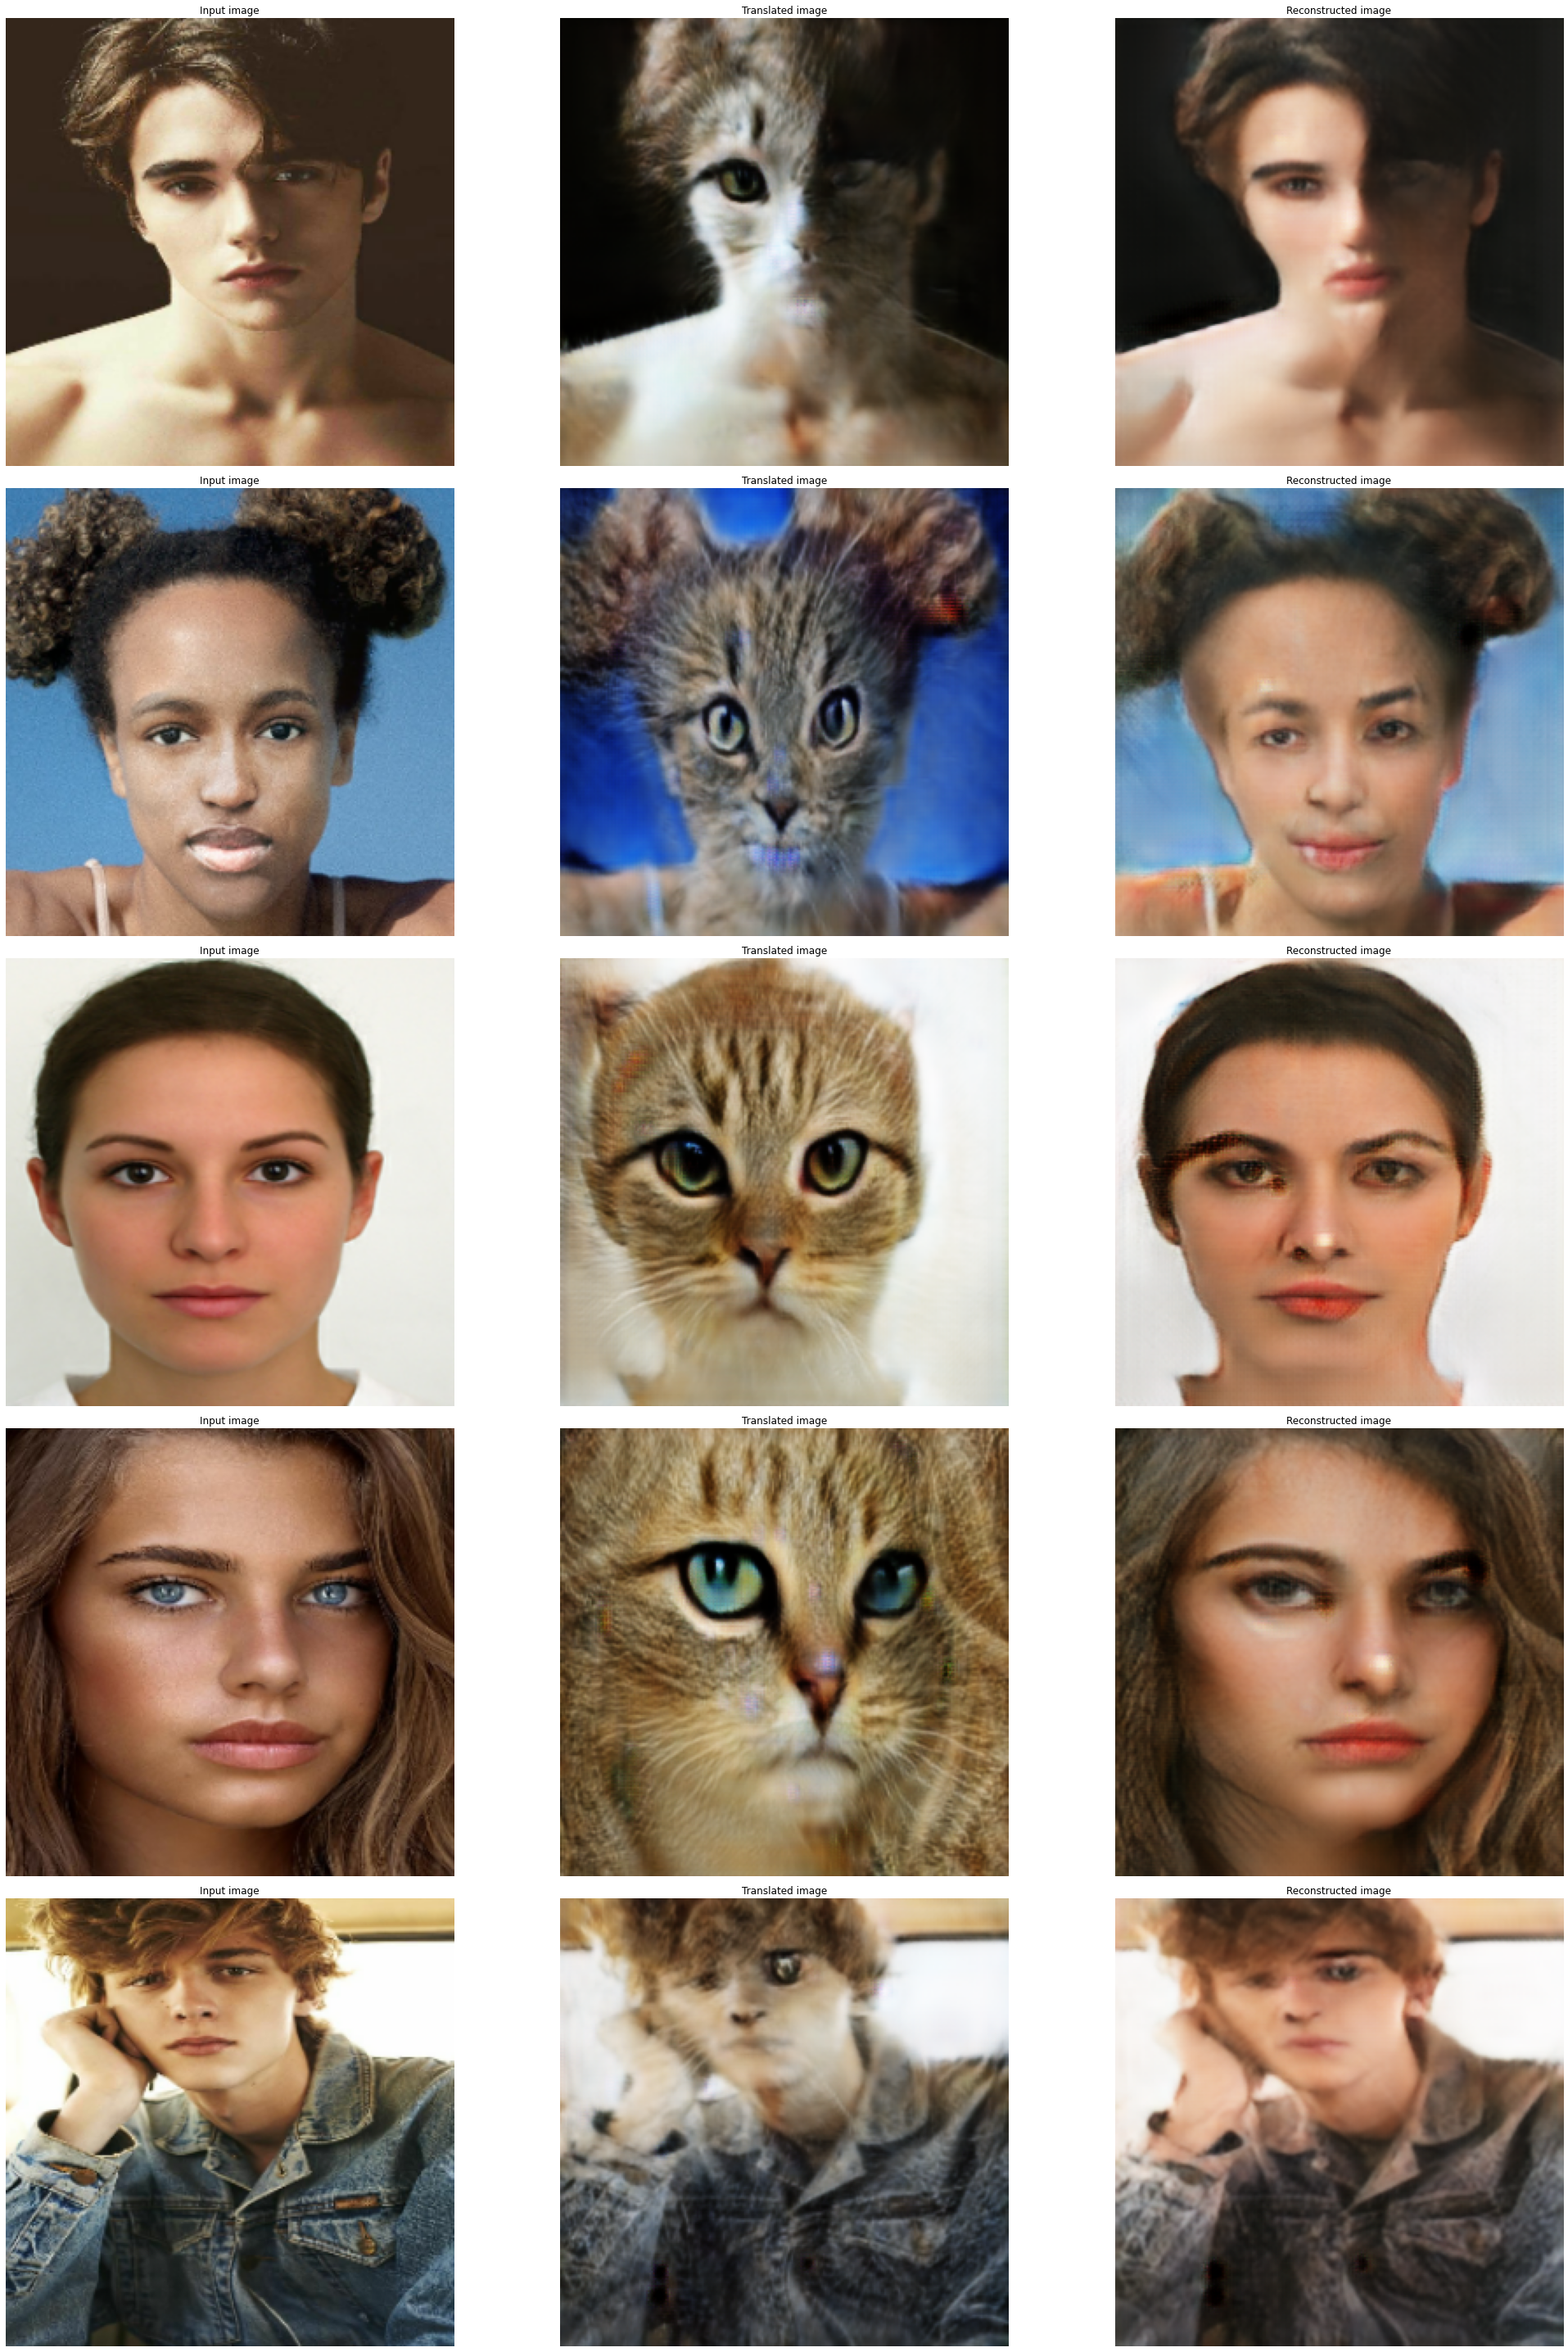

In [41]:

# Load the checkpoints
weight_file = "./checkpoints/cyclegan_checkpoints.068"
cycle_gan_model.load_weights(weight_file).expect_partial()
print("Weights loaded successfully")

_, ax = plt.subplots(5, 3, figsize=(30, 40))
for i, img in enumerate(processed_data1.skip(20).take(5)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    p=prediction[None,:,:,:]
    r_img=cycle_gan_model.gen_F(p,training=False)[0].numpy()
    
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    
    r_img=(r_img * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 2].imshow(r_img)
    ax[i, 0].set_title("Input image")
    ax[i, 2].set_title("Reconstructed image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")


    #prediction = keras.preprocessing.image.array_to_img(prediction)
    #prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()